In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler, RobustScaler

from utils.calculate_score import calculate_score

/var/folders/dl/_kvv4hhd1qb_h0ms_8jm1nkc0000gn/T/ipykernel_13592/2352106591.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Setting
location = "강남역"
keyword = "맛집"

columns_to_zero = ['instagram_post', 'instagram_follower',
                   'visitor_review_count', 'blog_review_count', 'distance_from_subway']

columns_to_false = ['on_tv', 'seoul_michelin', 'on_blue_ribbon', "no_kids",
                    "parking_available", "hot_spot", "age-2030", "gender-balance", "new_store"]


def calculate_consine_similarity(df1, df2):
    return cosine_similarity(df1, df2)


# Data Loading
crawled_data = pd.read_csv(
    f"data/crawl_result/{location}{keyword}.csv", header=0, encoding='utf-8-sig').drop('Unnamed: 0', axis=1).reset_index(drop=True)

datepop_data = pd.read_csv(
    f"data/datepop/shop_playing.csv", header=0, encoding='utf-8-sig').drop('Unnamed: 0', axis=1).reset_index(drop=True)
drop_features = ['instagram_post', 'instagram_follower',
                 'visitor_review_count', 'blog_review_count']
datepop_data = datepop_data[datepop_data['instagram_link'].notna() & (
    datepop_data['instagram_link'] != '')]
datepop_data = datepop_data[datepop_data[drop_features].notna().all(
    axis=1) & (datepop_data[drop_features] != 0).all(axis=1)]

for column in columns_to_zero:
    crawled_data[column].fillna(0, inplace=True)
    datepop_data[column].fillna(0, inplace=True)
for column in columns_to_false:
    crawled_data[column].fillna(False, inplace=True)
    datepop_data[column].fillna(False, inplace=True)

crawled_data.reset_index(drop=True, inplace=True)
datepop_data.reset_index(drop=True, inplace=True)

# Type Conversion
str_to_int_features = ['instagram_post', 'instagram_follower',
                       'visitor_review_count', 'blog_review_count', 'distance_from_subway']

for feature in str_to_int_features:
    crawled_data[feature] = crawled_data[feature].astype(int)
    datepop_data[feature] = datepop_data[feature].astype(int)

handled_data = crawled_data.copy()

# Feature Scaling
numeric_features = ['instagram_post', 'instagram_follower',
                    'visitor_review_count', 'blog_review_count']

robust_scaler = RobustScaler()
handled_data[numeric_features] = robust_scaler.fit_transform(
    handled_data[numeric_features])
datepop_data[numeric_features] = robust_scaler.transform(
    datepop_data[numeric_features])

min_max_scaler = MinMaxScaler()
handled_data[numeric_features] = min_max_scaler.fit_transform(
    handled_data[numeric_features])
datepop_data[numeric_features] = min_max_scaler.transform(
    datepop_data[numeric_features])

/var/folders/dl/_kvv4hhd1qb_h0ms_8jm1nkc0000gn/T/ipykernel_13592/1058055336.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  crawled_data[column].fillna(0, inplace=True)
/var/folders/dl/_kvv4hhd1qb_h0ms_8jm1nkc0000gn/T/ipykernel_13592/1058055336.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [3]:
# Similarity Calculation
# # 유사도 계산에 사용할 features
similarity_features = ['instagram_post', 'instagram_follower', 'visitor_review_count', 'blog_review_count']
average_similarity = []
for i, row in handled_data.iterrows():
    row_df = pd.DataFrame([row[similarity_features]])
    similarities = calculate_consine_similarity(row_df, datepop_data[similarity_features])[0]

    high_percent = np.percentile(similarities, 70)

    top_similarities = [sim for sim in similarities if sim >= high_percent]
   
    average_similarity.append(np.mean(top_similarities))

similarity_scores = [1 * math.pow(50, sim) for sim in average_similarity]
crawled_data.insert(2, 'similarity', similarity_scores)

# 결과 확인
pd.DataFrame(average_similarity).describe()


,0
count,1106.000000
mean,0.795373
std,0.143645
min,0.000000
25%,0.788630
50%,0.812586
75%,0.831070
max,0.999422


/var/folders/dl/_kvv4hhd1qb_h0ms_8jm1nkc0000gn/T/ipykernel_13592/3563754834.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(crawled_data['similarity'], hist=True)


<Axes: xlabel='similarity', ylabel='Density'>

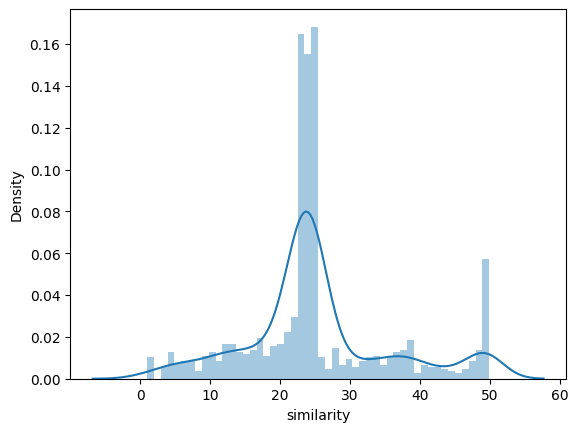

In [4]:
sns.distplot(crawled_data['similarity'], hist=True)

In [5]:
# Score Calculation
scores = []
for index, item in crawled_data.iterrows():
    score = calculate_score(item)
    scores.append(score)

crawled_data.insert(2, 'score', scores)

In [6]:
# Total Score
total_scores = []
for index, item in crawled_data.iterrows():
    score1 = item["similarity"]
    score2 = item["score"]

    total_scores.append(score1 + score2)

crawled_data.insert(2, 'total_score', total_scores)
crawled_data.sort_values(by="total_score", ascending=False,
                            ignore_index=True, inplace=True)

In [8]:
crawled_data.head(20)

,store_id,name,total_score,score,similarity,category,is_food,new_store,instagram_link,instagram_post,...,seoul_michelin,age-2030,gender-balance,on_blue_ribbon,image_urls,running_well,address,phone,gps,naver_url
0,1841724739,오레,80.448481,31,49.448481,"카페,디저트",True,True,https://instagram.com/ore.cafe_seoul,39,...,False,False,False,False,[],0,서울 강남구 강남대로124길 29 1층 104호,0507-1305-2135,"{'latitude': 37.5093564, 'longitude': 127.0251...",https://pcmap.place.naver.com/place/1841724739...
1,1149315406,마이블루투모로우 강남점,77.546864,28,49.546864,"카페,디저트",True,True,https://instagram.com/myblutomorrow,65,...,False,False,False,False,[],1,서울 서초구 강남대로 455 B1 112호,0507-1377-3279,"{'latitude': 37.5028558, 'longitude': 127.0245...",https://pcmap.place.naver.com/place/1149315406...
2,1466638126,유사길 혼술바,74.962270,33,41.962270,술집,True,True,https://instagram.com/yusagil_bar,20,...,False,False,False,False,[],0,서울 강남구 강남대로122길 31 louis 빌딩 4층 402호,010-4918-5747,"{'latitude': 37.508579, 'longitude': 127.0255043}",https://pcmap.place.naver.com/place/1466638126...
3,1980102719,다이닝오은,74.846416,25,49.846416,한식,True,True,https://instagram.com/diningoeun,37,...,False,False,False,False,[],1,"서울 서초구 강남대로85길 21-11 지하1층, 1층",0507-1406-4033,"{'latitude': 37.5067364, 'longitude': 127.0219...",https://pcmap.place.naver.com/place/1980102719...
4,1864945139,완미족발 논현2호점,74.769904,25,49.769904,"족발,보쌈",True,True,https://instagram.com/wanmi_jokbal_nonhyeon,190,...,False,False,False,False,[],1,서울 강남구 강남대로118길 21 지상 2층,0507-1398-6121,"{'latitude': 37.5069447, 'longitude': 127.0250...",https://pcmap.place.naver.com/place/1864945139...
5,1740499064,크림VIP라운지,66.126555,17,49.126555,"카페,디저트",True,False,https://instagram.com/cream_vip_lounge,75,...,False,False,False,False,[],0,서울 서초구 서초대로 411 GT타워 B1,0507-1476-0031,"{'latitude': 37.4979716, 'longitude': 127.0259...",https://pcmap.place.naver.com/place/1740499064...
6,36342895,할스,65.887013,16,49.887013,이탈리아음식,True,False,https://instagram.com/hearthseoul,849,...,False,True,True,False,[],0,서울 강남구 언주로93길 32-8 1층,02-501-9257,"{'latitude': 37.5038033, 'longitude': 127.0392...",https://pcmap.place.naver.com/place/36342895?e...
7,1367890809,도키메이테,65.788840,17,48.788840,일식당,True,False,https://instagram.com/tokimeite_official,423,...,False,False,False,False,[],0,서울 강남구 테헤란로4길 6 지하1층 B120호,0507-1368-8768,"{'latitude': 37.4976709, 'longitude': 127.029341}",https://pcmap.place.naver.com/place/1367890809...
8,1495671689,브레댄코 강남역점,64.839630,15,49.839630,베이커리,True,True,https://instagram.com/breadnco_kr,983,...,False,False,False,False,[],1,서울 서초구 서초대로74길 27 1층 101호,0507-1449-0103,"{'latitude': 37.4952966, 'longitude': 127.0272...",https://pcmap.place.naver.com/place/1495671689...
9,1495671689,브레댄코 강남역점,64.839630,15,49.839630,베이커리,True,True,https://instagram.com/breadnco_kr,983,...,False,False,False,False,[],1,서울 서초구 서초대로74길 27 1층 101호,0507-1449-0103,"{'latitude': 37.4952966, 'longitude': 127.0272...",https://pcmap.place.naver.com/place/1495671689...


In [9]:
crawled_data.head(20).to_csv(f'data/crawl_score/hybrid/{location}{keyword}_top20.csv', encoding='utf-8-sig')

In [10]:
crawled_data.sort_values(by='score', ascending=False,
                            ignore_index=True)

,store_id,name,total_score,score,similarity,category,is_food,new_store,instagram_link,instagram_post,...,seoul_michelin,age-2030,gender-balance,on_blue_ribbon,image_urls,running_well,address,phone,gps,naver_url
0,1466638126,유사길 혼술바,74.962270,33,41.962270,술집,True,True,https://instagram.com/yusagil_bar,20,...,False,False,False,False,[],0,서울 강남구 강남대로122길 31 louis 빌딩 4층 402호,010-4918-5747,"{'latitude': 37.508579, 'longitude': 127.0255043}",https://pcmap.place.naver.com/place/1466638126...
1,1841724739,오레,80.448481,31,49.448481,"카페,디저트",True,True,https://instagram.com/ore.cafe_seoul,39,...,False,False,False,False,[],0,서울 강남구 강남대로124길 29 1층 104호,0507-1305-2135,"{'latitude': 37.5093564, 'longitude': 127.0251...",https://pcmap.place.naver.com/place/1841724739...
2,1360925522,일지 강남점,46.339728,31,15.339728,차,True,True,https://instagram.com/teahouse_ilji,0,...,False,False,False,False,[],0,서울 강남구 강남대로92길 19 1층,0507-1478-1703,"{'latitude': 37.4991837, 'longitude': 127.0289...",https://pcmap.place.naver.com/place/1360925522...
3,1360925522,일지 강남점,46.339728,31,15.339728,차,True,True,https://instagram.com/teahouse_ilji,0,...,False,False,False,False,[],0,서울 강남구 강남대로92길 19 1층,0507-1478-1703,"{'latitude': 37.4991837, 'longitude': 127.0289...",https://pcmap.place.naver.com/place/1360925522...
4,1829829092,도른계 강남역점,48.099269,31,17.099269,"치킨,닭강정",True,True,https://instagram.com/dorngye,80,...,False,False,False,False,[],0,서울 강남구 강남대로96길 12 1층 102호,0507-1351-5063,"{'latitude': 37.4997492, 'longitude': 127.028088}",https://pcmap.place.naver.com/place/1829829092...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1101,11701239,대풍 간장게장 생선구이,24.281975,0,24.281975,생선구이,True,False,NaN,0,...,False,False,False,False,[],0,서울 서초구 신반포로47길 72 우리빌 1층,02-518-7357,"{'latitude': 37.5134618, 'longitude': 127.0186...",https://pcmap.place.naver.com/place/11701239?e...
1102,30922907,스파게티스토리,24.272682,0,24.272682,스파게티스토리,True,False,NaN,0,...,False,False,False,False,[],0,서울 강남구 남부순환로359길 20,02-3463-5677,"{'latitude': 37.48616, 'longitude': 127.036483}",https://pcmap.place.naver.com/place/30922907?e...
1103,36395141,갈쿠리와 소쿠리,24.266258,0,24.266258,한식,True,False,NaN,0,...,False,False,True,False,[],0,서울 서초구 신반포로45길 50-9,02-544-4819,"{'latitude': 37.512731, 'longitude': 127.017896}",https://pcmap.place.naver.com/place/36395141?e...
1104,1216275335,만덕식당,24.258922,0,24.258922,한식,True,False,NaN,0,...,False,False,False,False,[],0,서울 서초구 서초대로58길 31-11 우진빌딩 1층 만덕식당,02-6409-8586,"{'latitude': 37.4936918, 'longitude': 127.0185...",https://pcmap.place.naver.com/place/1216275335...
